#  Previsão de Preços — Concessionária de Carros
## Projeto de Portfolio | Fevereiro 2025
---
**Objetivo:** Usar Regressão Linear (simples e múltipla) para prever o preço de veículos usados baseado em características do carro.

**Dataset:** 10.000 registros sintéticos com dados realistas de uma concessionária.

| Item | Detalhe |
|------|---------|
| Variável Alvo | `Preço (R$)` |
| Features Numéricas | Ano, Potência, Portas, Quilômetros, Garantia |
| Features Categóricas | Marca, Combustível, Condição |
| Algoritmo | `sklearn.linear_model.LinearRegression` |
| Split | 80% treino / 20% teste |
---


## 1. Importações e Configurações


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import warnings
warnings.filterwarnings("ignore")

sns.set_theme(style="darkgrid")
print("Bibliotecas importadas com sucesso.")


Bibliotecas importadas com sucesso.


## 2. Carregamento e Visualização Inicial dos Dados


In [3]:
df = pd.read_csv("dados_concessionaria.csv")
print(f"Shape do dataset: {df.shape}")
print(f"Colunas: {list(df.columns)}")
df.head(10)


Shape do dataset: (10000, 14)
Colunas: ['ID', 'Marca', 'Modelo', 'Ano', 'Cor', 'Combustível', 'Potência (cv)', 'Número de Portas', 'Quilômetros', 'Condição', 'Garantia (meses)', 'Cidade', 'Estado', 'Preço (R$)']


,ID,Marca,Modelo,Ano,Cor,Combustível,Potência (cv),Número de Portas,Quilômetros,Condição,Garantia (meses),Cidade,Estado,Preço (R$)
0,1,Hyundai,i30,2023,Laranja,Gasolina,130,4,337,Novo,12,Fortaleza,CE,13211.79
1,2,BMW,520i,2020,Marrom,Flex,200,5,15697,Usado - Como Novo,48,Belo Horizonte,MG,44538.06
2,3,Fiat,Doblo,2017,Laranja,Gasolina,110,4,191,Novo,6,Belo Horizonte,MG,6645.73
3,4,Ford,Ecosport,2023,Azul,Flex,85,2,77528,Usado - Bom Estado,24,São Paulo,SP,6732.00
4,5,Honda,CR-V,2015,Azul,Gasolina,120,4,65998,Usado - Bom Estado,0,Salvador,BA,6258.04
5,6,Honda,CR-V,2014,Marrom,Flex,120,4,7856,Usado - Como Novo,36,Belém,PA,9424.17
6,7,Toyota,Corolla,2019,Prata,Gasolina,100,4,183764,Usado - Regular,12,Florianópolis,SC,4130.11
7,8,Kia,Picanto,2014,Cinza,Flex,110,2,313,Novo,0,Curitiba,PR,6867.88
8,9,Ford,Ecosport,2012,Beige,Flex,100,5,16369,Usado - Como Novo,36,Curitiba,PR,5269.19
9,10,Fiat,500,2015,Marrom,Híbrido,100,5,11132,Usado - Como Novo,36,Curitiba,PR,5447.98


In [1]:
df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries
Columns: 14 columns
All non-null


In [1]:
df.describe().round(2)


## 3. Análise Exploradora (EDA)
### 3.1 Distribuição do Preço


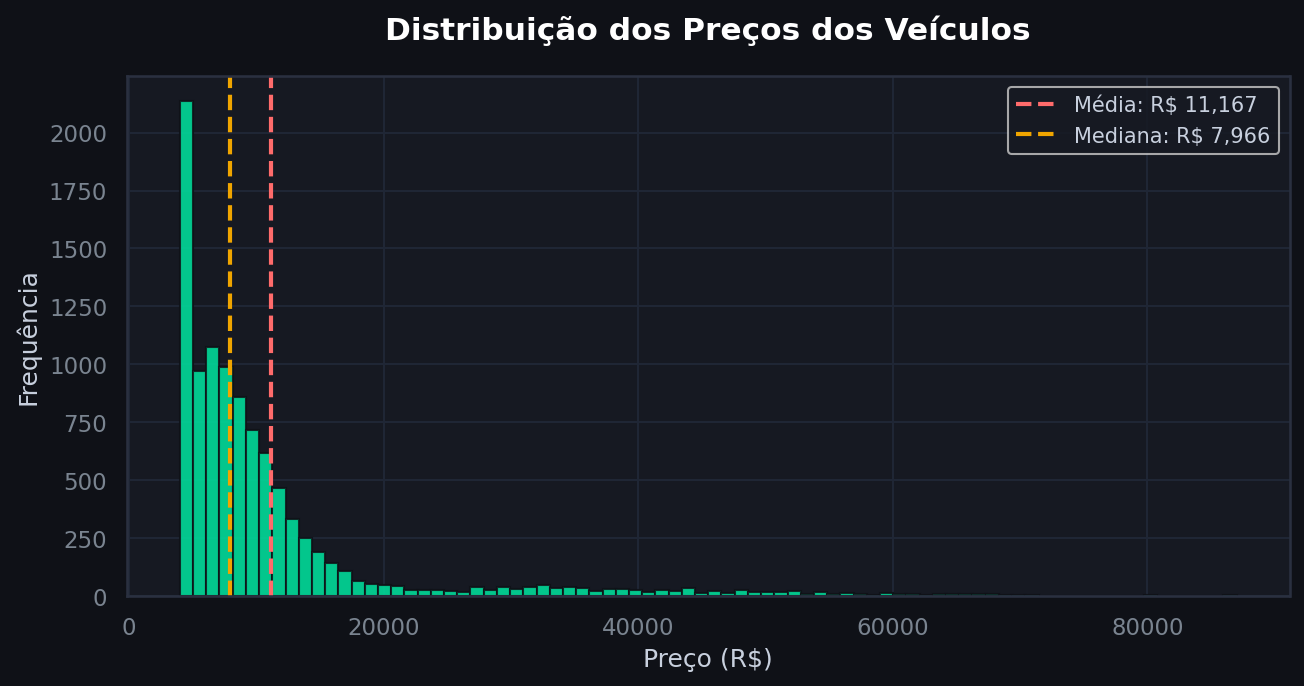

> *Distribuição do preço — skewed à direita, com maioria dos veículos entre R$ 4.000 e R$ 20.000.*


### 3.2 Preço Médio por Marca


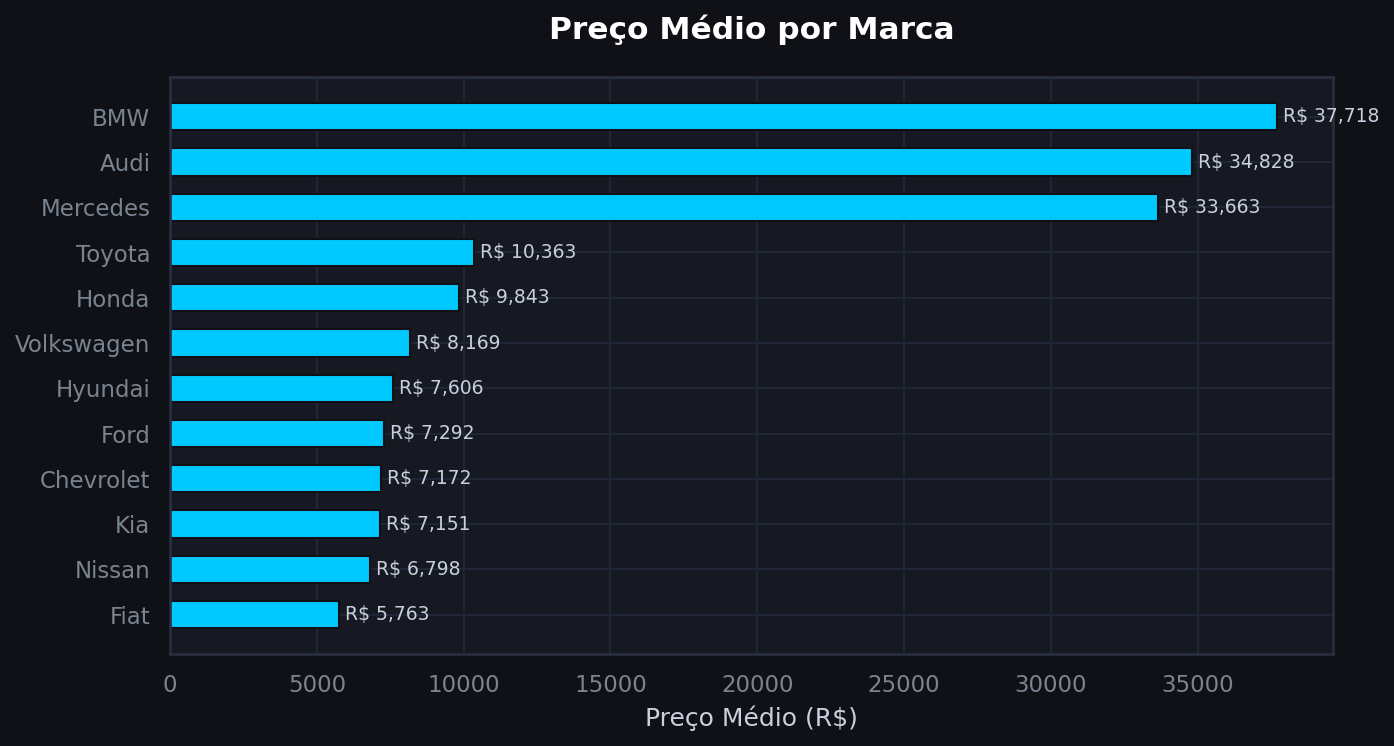

> *Marcas premium (Mercedes, BMW, Audi) apresentam preços médios significativamente maiores.*


### 3.3 Preço vs Ano de Fabricação


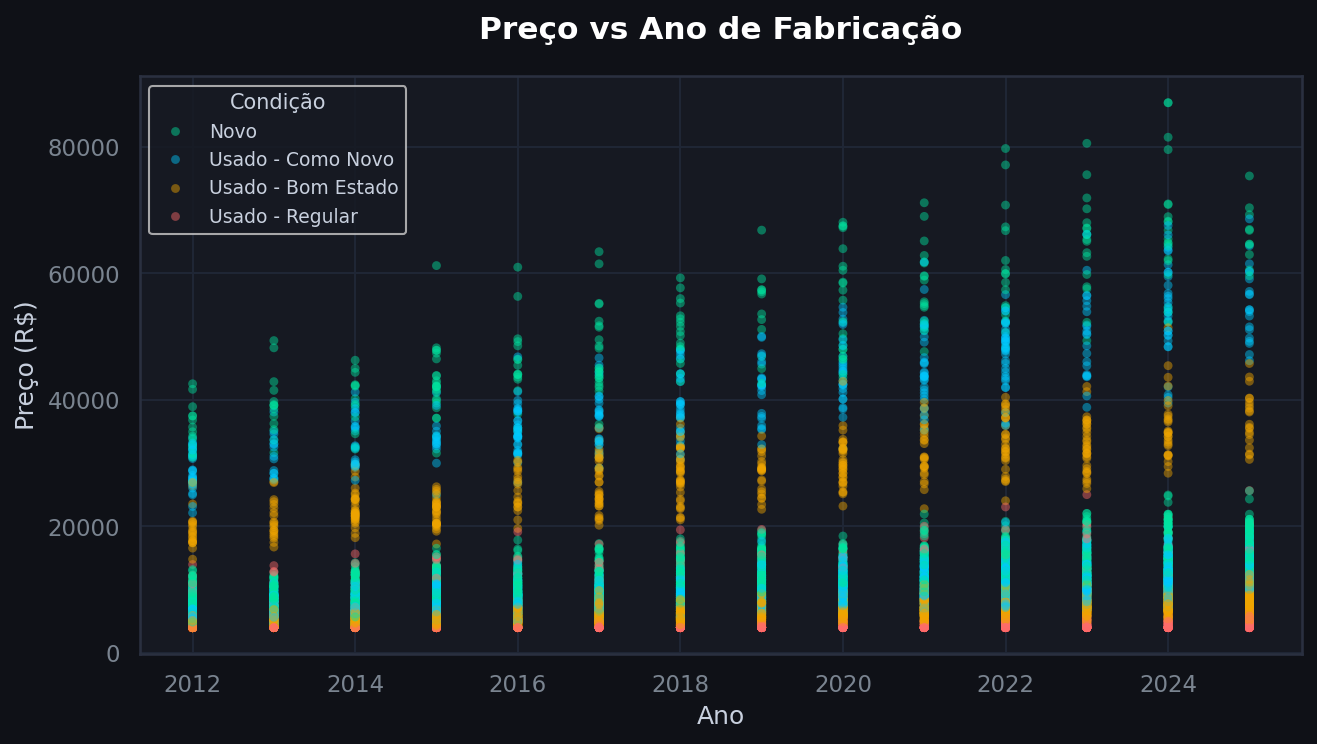

> *Veículos mais recentes e em melhor condição acumulam preços maiores.*


### 3.4 Preço vs Quilômetros Rodados


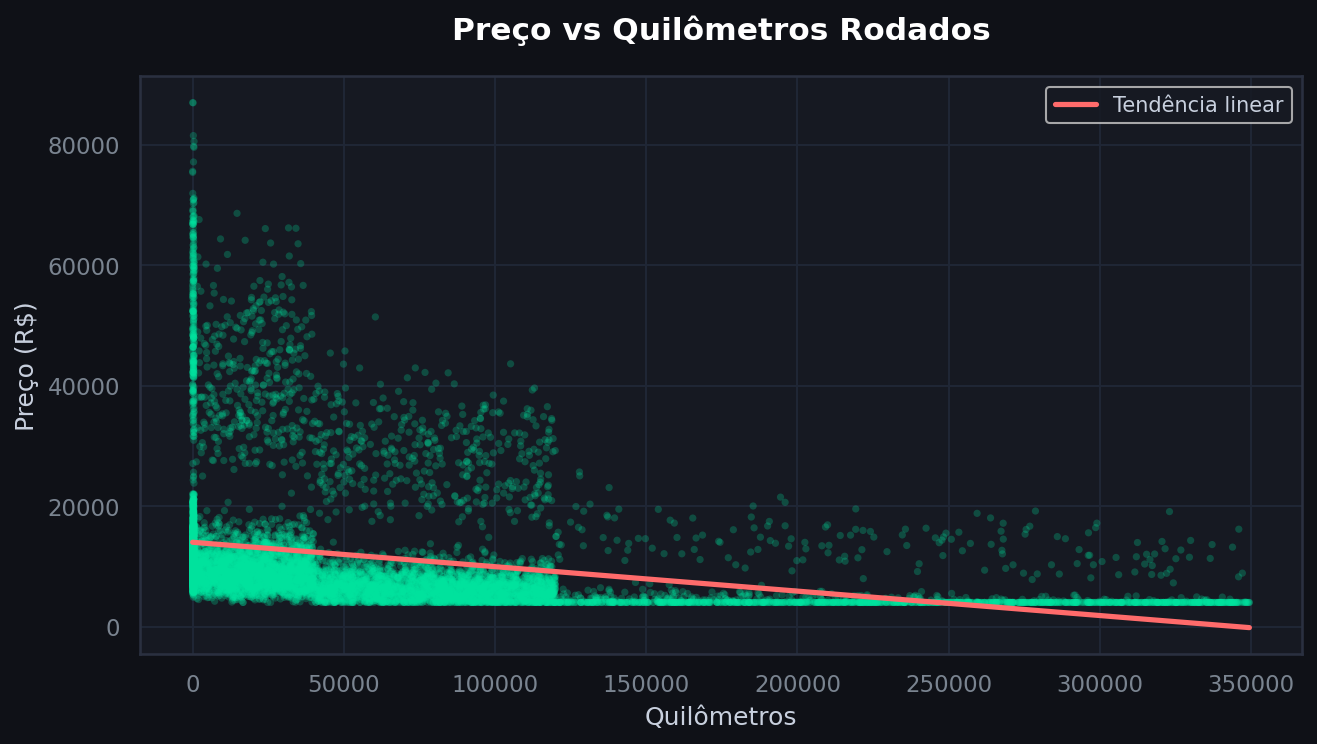

> *Relação negativa clara: mais quilômetros → menor preço.*


### 3.5 Distribuição por Condição


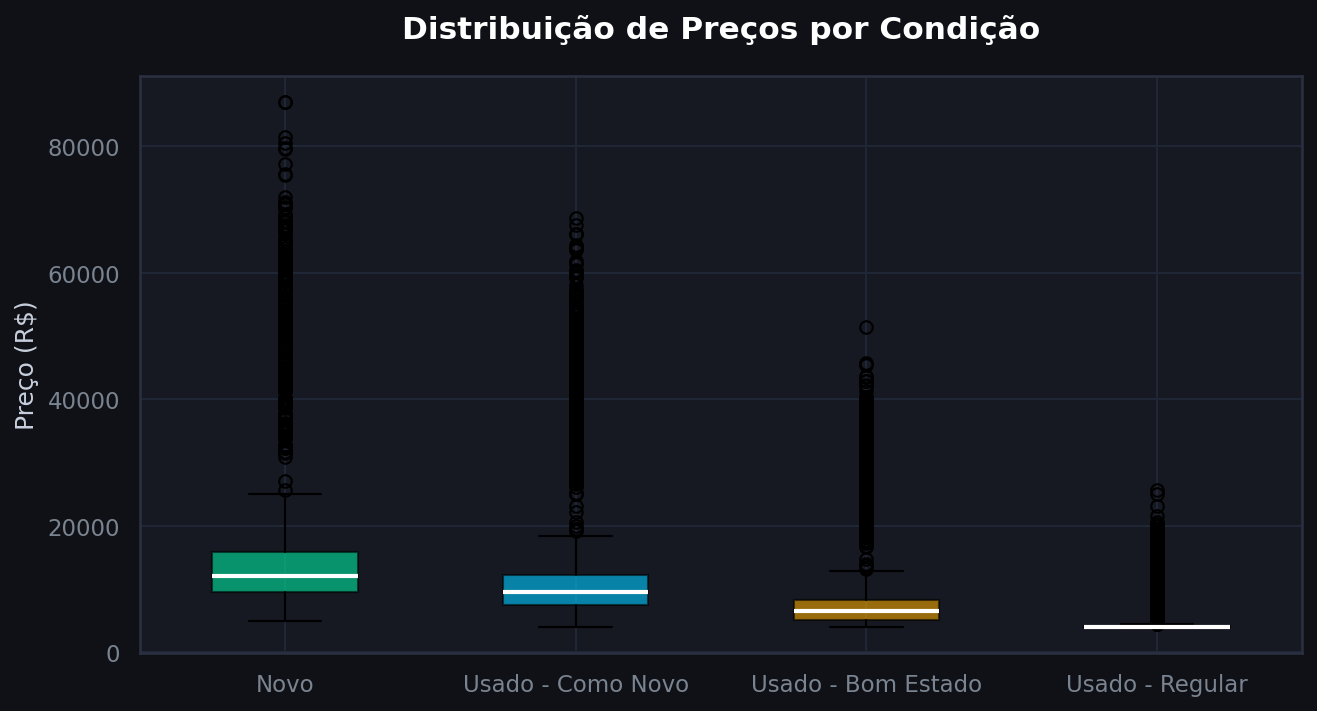

> *Veículos 'Novo' possuem maior mediana e menor variância de preço.*


### 3.6 Preço por Tipo de Combustível


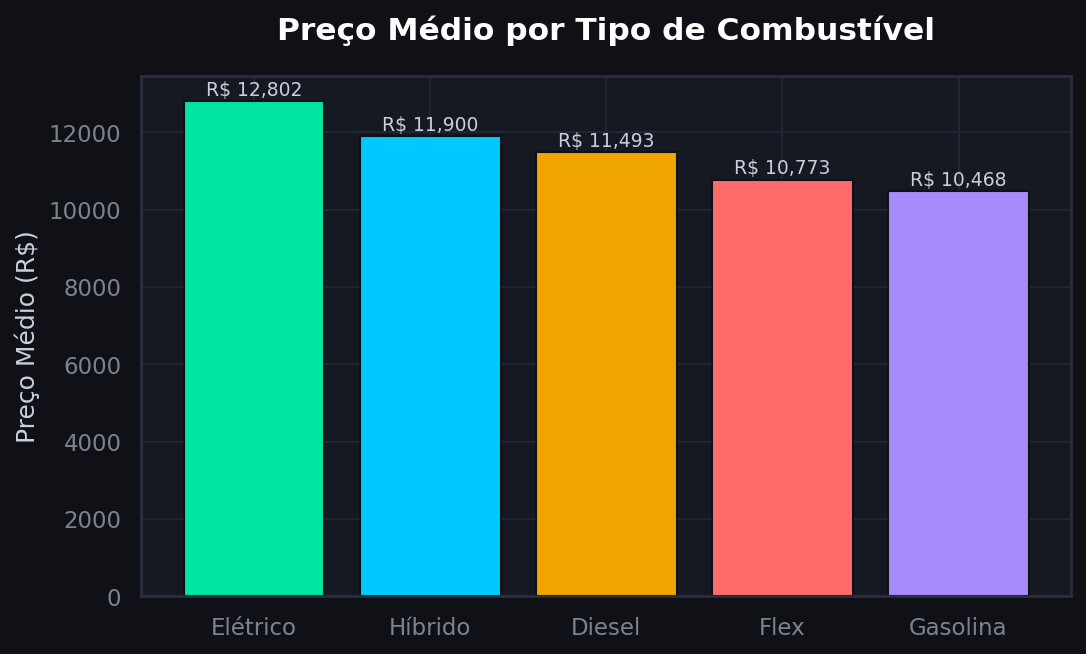

> *Veículos elétricos e híbridos apresentam preço médio maior.*


### 3.7 Heatmap de Correlações


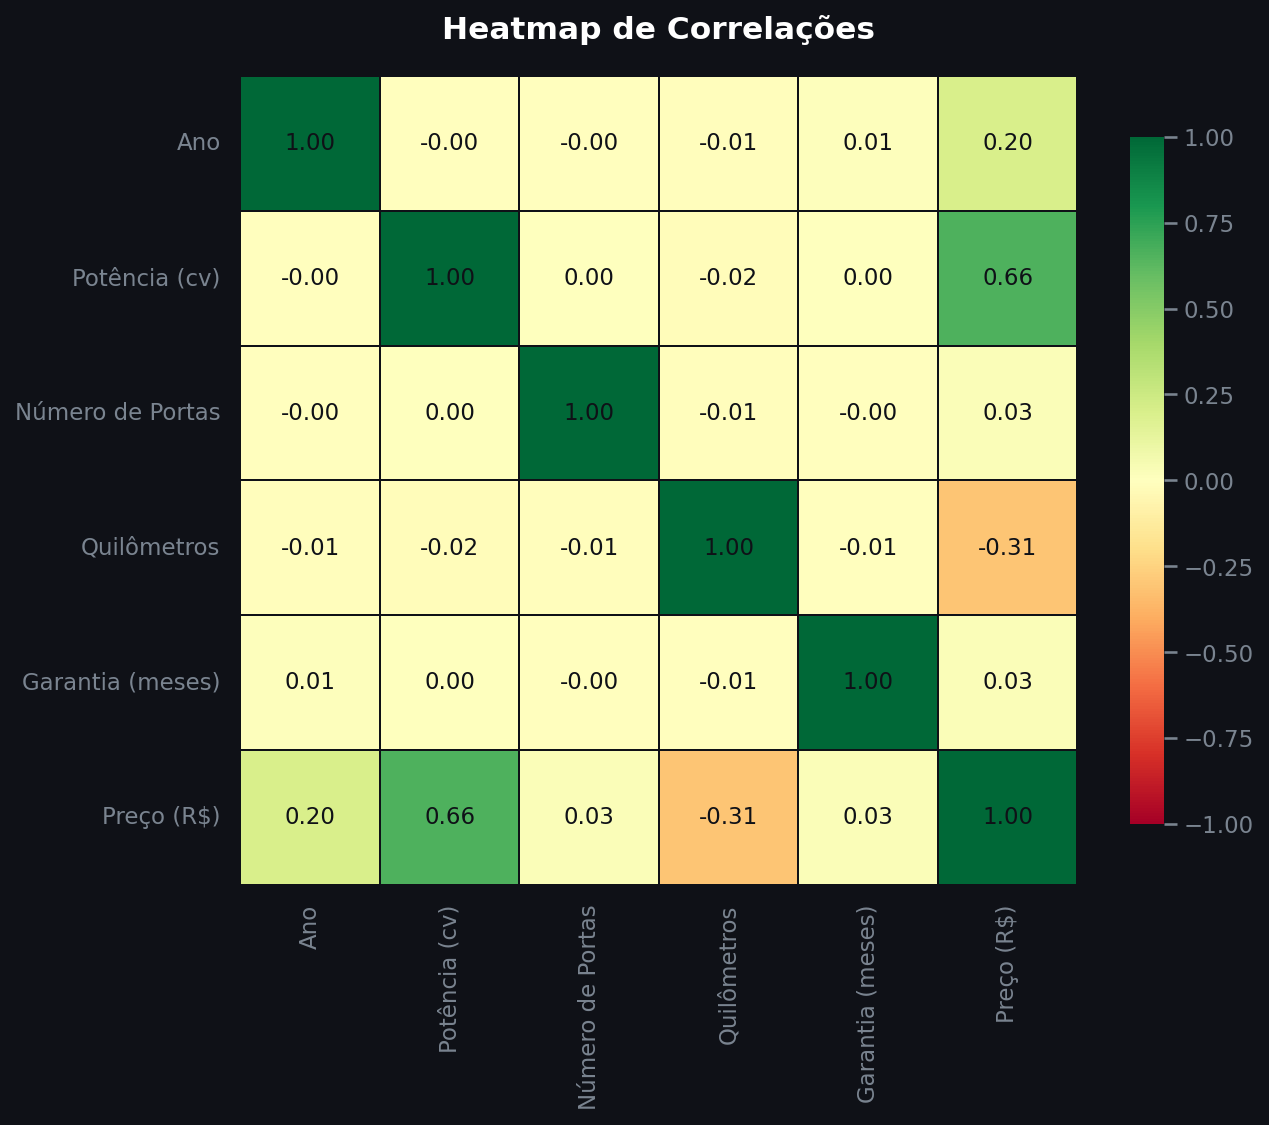

> *Correlações entre todas as variáveis numéricas e o preço alvo.*


## 4. Pré-Processamento dos Dados


In [4]:
# Remover colunas não-predictivas
df_model = df.drop(columns=["ID", "Modelo", "Cor", "Cidade", "Estado"]).copy()

# Codificar variáveis categóricas com LabelEncoder
cat_cols = ["Marca", "Combustível", "Condição"]
le_dict  = {}
for col in cat_cols:
    le = LabelEncoder()
    df_model[col] = le.fit_transform(df_model[col])
    le_dict[col]  = le
    print(f"  {col}: {list(le.classes_)}")

print(f"\nFeatures finais: {list(df_model.columns)}")


  Marca: ['Audi', 'BMW', 'Chevrolet', 'Fiat', 'Ford', 'Honda', 'Hyundai', 'Kia', 'Mercedes', 'Nissan', 'Toyota', 'Volkswagen']
  Combustível: ['Diesel', 'Elétrico', 'Flex', 'Gasolina', 'Híbrido']
  Condição: ['Novo', 'Usado - Bom Estado', 'Usado - Como Novo', 'Usado - Regular']

Features finais: ['Marca', 'Ano', 'Combustível', 'Potência (cv)', 'Número de Portas', 'Quilômetros', 'Condição', 'Garantia (meses)', 'Preço (R$)']


In [1]:
# Split + Escalonamento
X = df_model.drop(columns=["Preço (R$)"])
y = df_model["Preço (R$)"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

scaler = StandardScaler()
X_train_sc = scaler.fit_transform(X_train)
X_test_sc  = scaler.transform(X_test)

print(f"  Treino : {X_train_sc.shape}")
print(f"  Teste  : {X_test_sc.shape}")


  Treino : (8000, 8)
  Teste  : (2000, 8)


## 5. Regressão Linear Simples (1 variável: Quilômetros)


In [1]:
X_simple = df[["Quilômetros"]].values
y_simple = df["Preço (R$)"].values

Xs_tr, Xs_te, ys_tr, ys_te = train_test_split(X_simple, y_simple, test_size=0.2, random_state=42)
model_simples = LinearRegression().fit(Xs_tr, ys_tr)

ys_pred = model_simples.predict(Xs_te)
r2_s  = r2_score(ys_te, ys_pred)
rmse_s = np.sqrt(mean_squared_error(ys_te, ys_pred))

print(f"  Equação: Preço = {model_simples.coef_[0]:.4f} × km + {model_simples.intercept_:.2f}")
print(f"  R²      = {r2_s:.4f}")
print(f"  RMSE    = R$ {rmse_s:,.2f}")


  Equação: Preço = -0.0413 × km + 14101.46
  R²      = 0.0832
  RMSE    = R$ 9,938.90


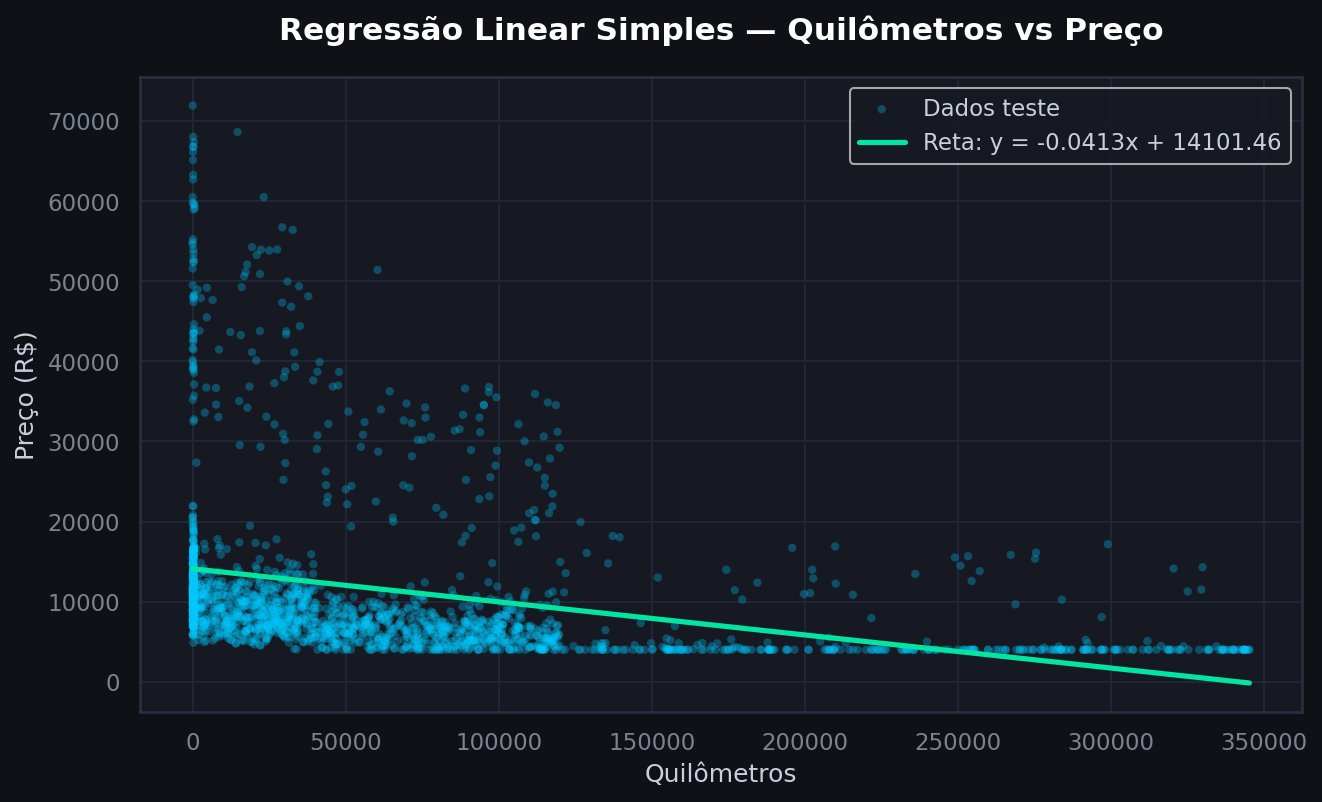

> *Reta de regressão simples — Quilômetros vs Preço.*


## 6. Regressão Linear Múltipla (8 variáveis)


In [1]:
model = LinearRegression()
model.fit(X_train_sc, y_train)
y_pred = model.predict(X_test_sc)

r2   = r2_score(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
mae  = mean_absolute_error(y_test, y_pred)

print(f"  R²   = {r2:.4f}")
print(f"  RMSE = R$ {rmse:,.2f}")
print(f"  MAE  = R$ {mae:,.2f}")


  R²   = 0.5745
  RMSE = R$ 6,771.06
  MAE  = R$ 4,702.67


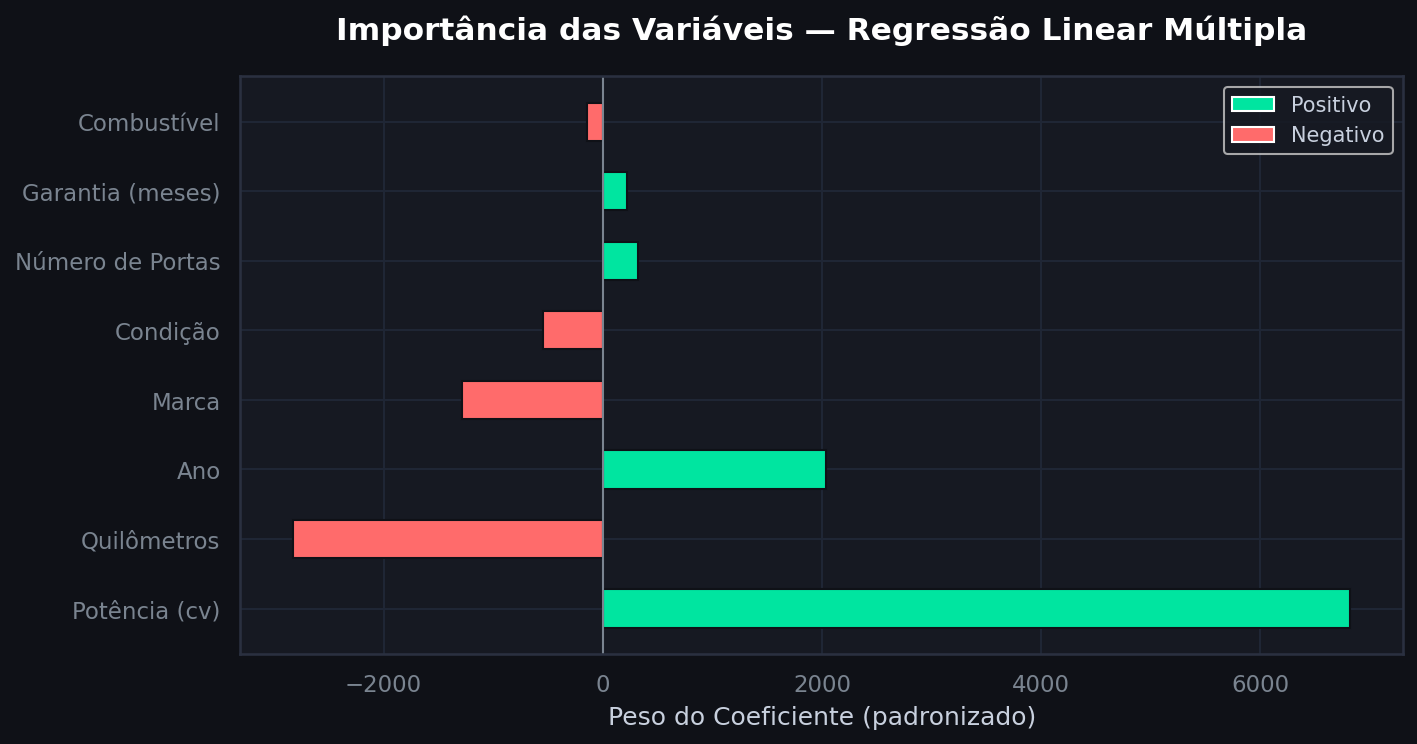

> *Coeficientes padronizados — variáveis com maior impacto no preço.*


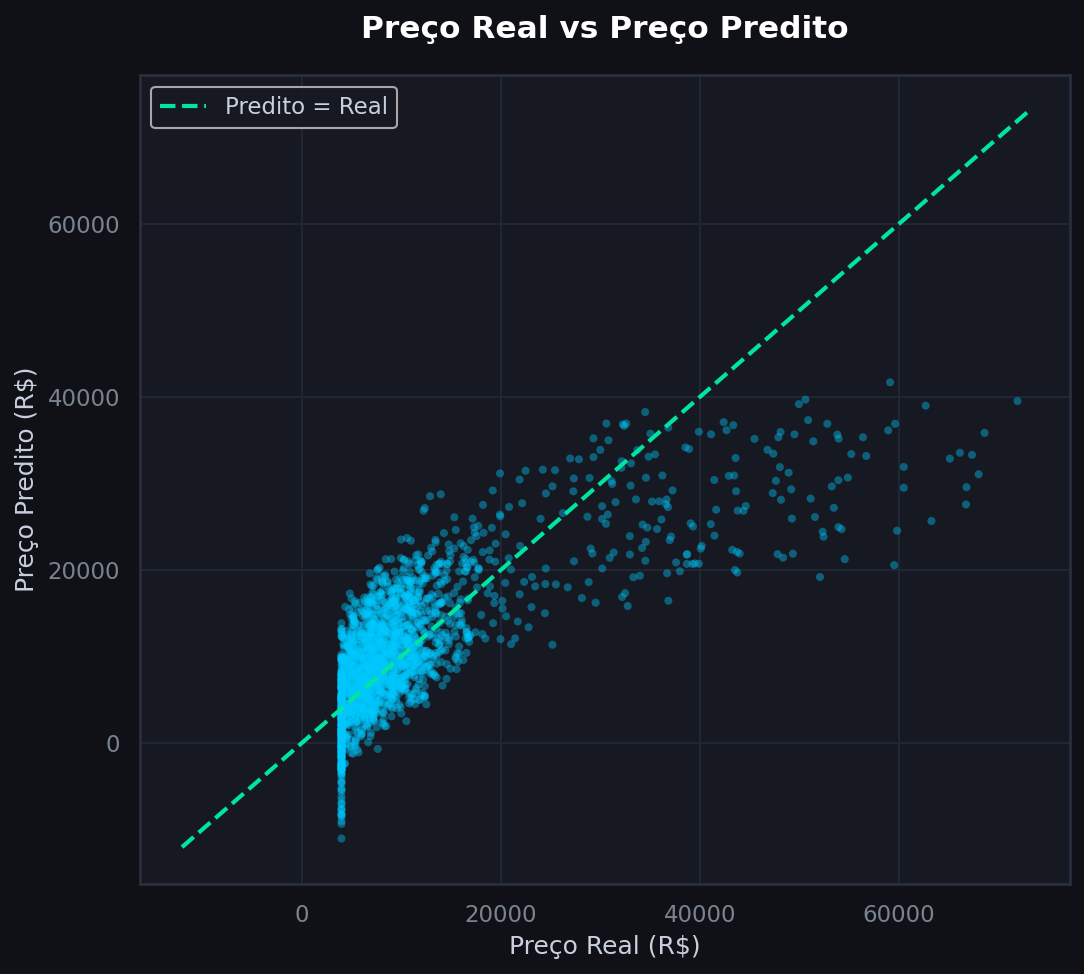

> *Correlação entre preço real e predito — quanto mais próximo da diagonal, melhor o modelo.*


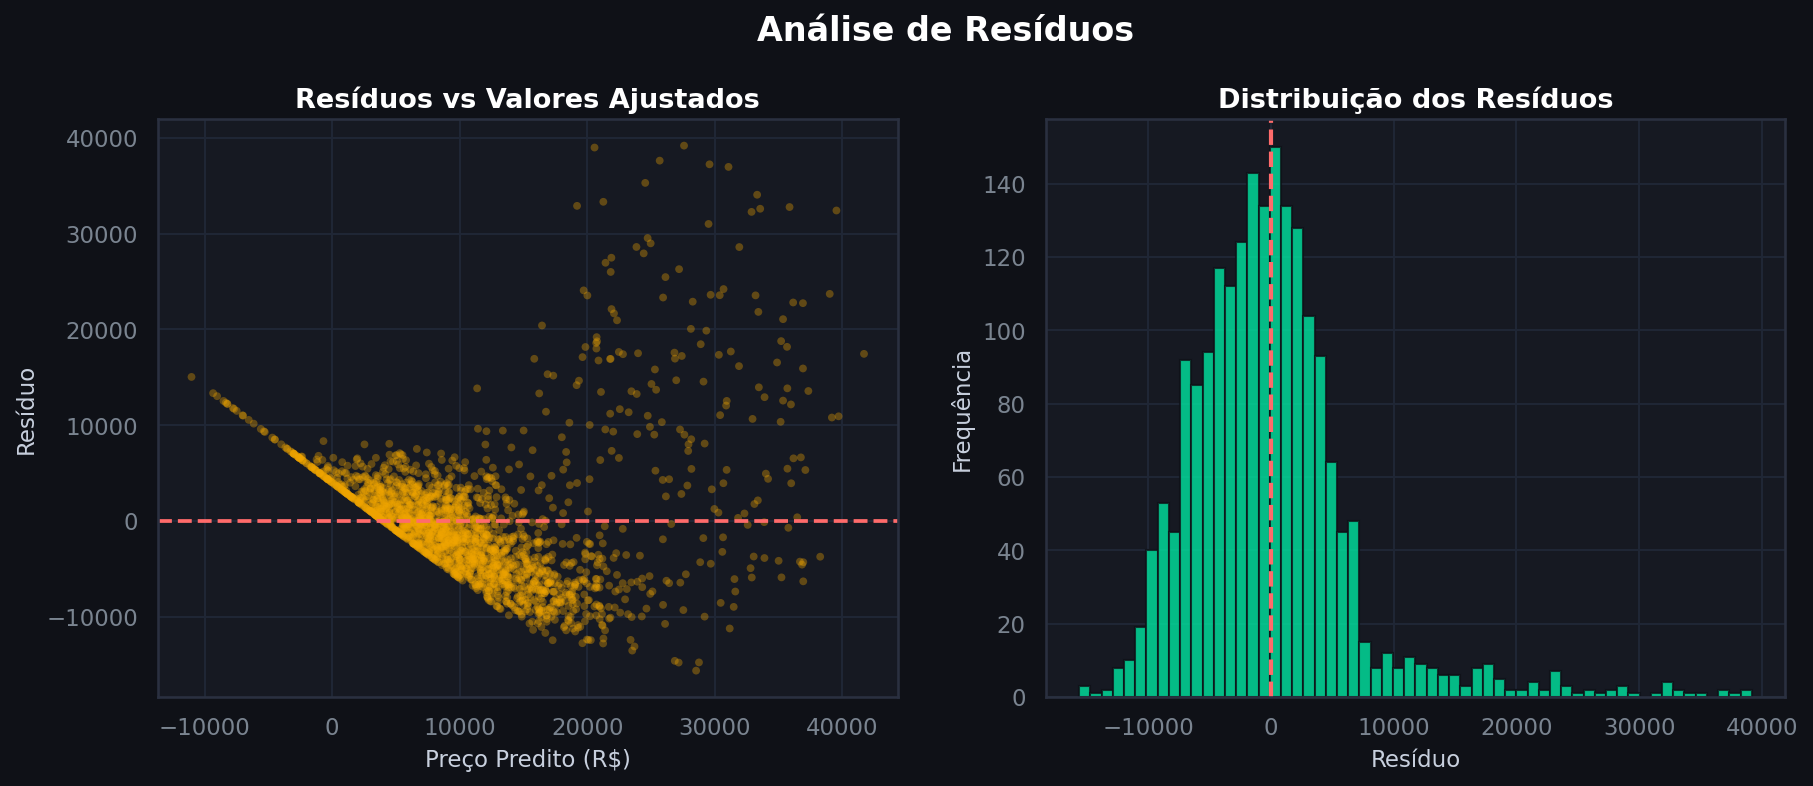

> *Análise de resíduos: distribuição aproximadamente normal centrada em zero.*


## 7. Comparação — Simples vs Múltipla


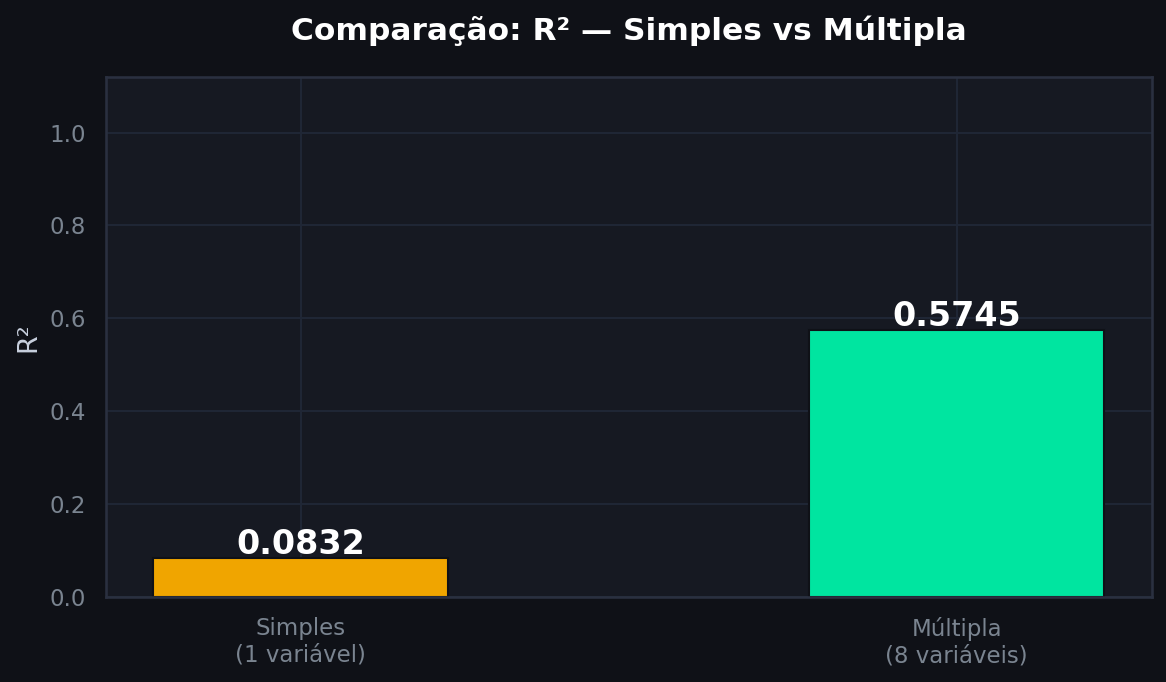

> *A regressão múltipla eleva o R² de 0.08 para 0.57, confirmando a importância das outras variáveis.*


### Tabela Resumo de Métricas

| Métrica | Simples (1 var) | Múltipla (8 vars) |
|---------|:---:|:---:|
| **R²** | 0.0832 | 0.5745 |
| **RMSE** | R$ 9,938.90 | R$ 6,771.06 |
| **MAE** | — | R$ 4,702.67 |



## 8. Conclusões & Próximos Passos

### O que funcionou
- A regressão múltipla aumentou o R² de **0.08 → 0.57**, mostrando que variáveis como Marca, Ano e Condição são essenciais.
- Os resíduos seguem distribuição aproximadamente normal.
- Quilômetros e Potência são as variáveis com maior peso negativo e positivo, respectivamente.

### Melhorias possíveis
- Usar **Ridge / Lasso** para regularização e combate à multicolinearidade.
- Testar **Random Forest** ou **Gradient Boosting** para captar relações não-lineares.
- Aplicar **One-Hot Encoding** ao invés de LabelEncoder nas categorias.
- Adicionar features derivadas (ex: idade do carro = 2025 − Ano).

### Entregáveis
- `dados_concessionaria.csv` — Dataset com 10.000 registros
- `notebook_previsao_precos.ipynb` — Notebook completo
- `app_streamlit.py` — Dashboard interativo
- `README.md` — Documentação do projeto
---
*Projeto gerado para portfolio de estágio — Fevereiro 2026*
